In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np 
import matplotlib.pyplot as plt
import functions as f
from PIL import Image

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
#Inititate constants
PROCESS_DATA = 1 #Change to 1 when training
TRAINING_DATA = 1 #Change to 1 if want model to be trained again

In [4]:
#Inititate constants
BATCH_SIZE = 64
IMG_SIZE = 28

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [6]:
if PROCESS_DATA:
    dataset = datasets.FashionMNIST("data",train = True,transform=data_transform,download = True)
    trainloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle = True)

In [7]:
#Show training data size
print(len(dataset))

60000


In [8]:
#Show training labels
CLASSES = dataset.classes
print(CLASSES)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


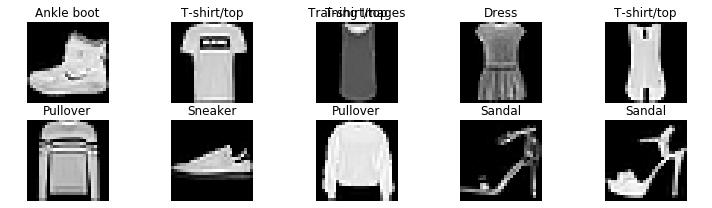

In [9]:
#Visualize some samples
def visualize_samples(NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(10,3))
    plt.title("Training Images")
    plt.axis("off")
    plt.tight_layout()
    for id in range(NUM_PIC):
        fig.add_subplot(2,NUM_PIC/2,id+1)
        img,label = dataset[id]
        img = img.numpy().transpose((1,2,0))
        img = img.squeeze()
        plt.axis("off")
        plt.title(CLASSES[label])
        plt.imshow(img, cmap="gray")
    plt.show()

visualize_samples(10)

In [10]:
LATENT_SIZE = 100
NUM_CLASSES = len(CLASSES)

In [11]:
#Make latent vector by creating random Gaussian noise
def random_noise(size):
    noise = torch.randn(size,LATENT_SIZE,1,1)
    noise = Variable(noise).to(device)
    return noise

In [12]:
one_hot = torch.zeros((10, 10))
one_hot = one_hot.scatter_(1, torch.LongTensor(range(10)).view(10, 1), 1).view(10, 10, 1, 1)
# Generate shape: 10*10*1*1

fill = torch.zeros((10, 10, IMG_SIZE, IMG_SIZE))
for i in range(10):
    fill[i, i, :, :] = 1
#Generate class: shape 10*10*32*32

In [13]:
def generate_fake_classes(size,c):
    fake_classes = (torch.rand((size)) * 10).type(torch.LongTensor)
    if c=="D":
        fake_classes = fill[fake_classes]
        #Output shape: 10*32*32
    elif c=="G":
        fake_classes = one_hot[fake_classes]
        #Output shape: 10*1*1
    return Variable(fake_classes).to(device)

In [14]:
#Generate labels for loss fuction
def generate_labels(size, label):
    if label:
        data = torch.ones(size,1) - 0.1
    else:
        data = torch.zeros(size,1)
    data = Variable(data).to(device)
    return data.view(-1)

In [15]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main1 = nn.Sequential(
            nn.ConvTranspose2d(100,128*4-10,4,1,0),
            nn.BatchNorm2d(128*4-10),
            nn.ReLU(True),
        )
            #Latent shape: (128*4-10)*7*7
            
        self.main2 = nn.Sequential(
            nn.ConvTranspose2d(10,10,4,1,0),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
        )
            #Label shape: 10*7*7
            
            #Then concat into shape (256*2)*7*7
        self.main3 = nn.Sequential(
        
            nn.ConvTranspose2d(128*4,128*2,4,1,0),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),
            # Output shape: 256*14*14
            
            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output shape: 128*28*28
            
            nn.ConvTranspose2d(128,1,4,2,1),
            nn.Tanh()
            # Output shape: 1*28*28
        )
    def forward(self, x, y):
        x = self.main1(x)
        y = self.main2(y)
        x = torch.cat([x, y], 1)
        x = self.main3(x)
        return x

In [17]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #Input shape: 1*28*28
        self.main1 = nn.Sequential(
            nn.Conv2d(1,118,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace= True),
        )
        #Latent shape: 118*14*14
        
        #Input shape: 10*28*28
        self.main2 = nn.Sequential(
            nn.Conv2d(10,10,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace= True),
        )
        #Label shape: 10*14*14
        
        #Concat both in to shape: 128*14*14
        self.main3 = nn.Sequential(
            nn.Conv2d(128,128*2,4,2,1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace= True),
            #Output shape: 256*14*14
            
            nn.Conv2d(128*2,128*4,4,2,1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace= True),
            #Output shape: 512*7*7
            
            nn.Conv2d(128*4,1,3,1,0, bias=False),
            nn.Sigmoid()
            #Output shape: 1
        )

    def forward(self, x , y):
        x = self.main1(x)
        y = self.main2(y)
        x = torch.cat([x, y], 1)
        x = self.main3(x)
        return x.view(-1)

In [18]:
def train_discriminator(D, G, optimizer, error, real_batch, real_classes_batch):
    batch_size = real_batch.size(0)
    optimizer.zero_grad()
    
    real_classes = Variable(fill[real_classes_batch]).to(device)
    fake_classes_G = generate_fake_classes(batch_size,"G")
    fake_classes_D = generate_fake_classes(batch_size,"D")
    
    fake_data = G(random_noise(batch_size), fake_classes_G).detach()
    real_data = Variable(real_batch.view(-1,1,IMG_SIZE,IMG_SIZE))
    
    real_data = real_data.to(device)
    fake_data = fake_data.to(device)

    prediction_real = D(real_data,real_classes)
    real_label = generate_labels(batch_size,1)
    loss_real = error(prediction_real,real_label)
    
    prediction_fake = D(fake_data,fake_classes_D)
    fake_label = generate_labels(batch_size,0)
    loss_fake = error(prediction_fake, fake_label)
    
    loss = loss_fake + loss_real
    loss.backward()
    
    D_x = prediction_real.mean().item()
    D_g_z1 = prediction_fake.mean().item()
    optimizer.step()

    return loss_real.data + loss_fake.data, D_x, D_g_z1

In [19]:
def train_generator(D,G,  optimizer, error, real_batch):
    batch_size = real_batch.size(0)
    optimizer.zero_grad()
    
    fake_classes_G = generate_fake_classes(batch_size,"G")
    fake_classes_D = generate_fake_classes(batch_size,"D")
    
    fake_data = G(random_noise(batch_size),fake_classes_G)
    
    fake_data = fake_data.to(device)
    prediction = D(fake_data, fake_classes_D)
    
    label = generate_labels(batch_size, 1)
    loss = error(prediction, label)
    loss.backward()
    D_g_z2 = prediction.mean().item()
    optimizer.step()
    return loss.data, D_g_z2

In [20]:
def generate_img(G,noise):
    G.eval()
    fig = plt.figure(figsize=(10,4))
    classes = torch.LongTensor([i for i in range(NUM_CLASSES)])
    classes = Variable(one_hot[classes]).to(device)
    with torch.no_grad():
        test_img = G(noise, classes).view(-1,IMG_SIZE,IMG_SIZE).cpu().numpy()
        for id, i in enumerate(test_img):
            fig.add_subplot(2,5,id+1)
            plt.axis("off")
            plt.imshow(i,cmap="gray")
    plt.show()
    G.train()

In [21]:
#Generate latent vector
test_noise = random_noise(10)

In [22]:
def train(D, G, D_optimizer, G_optimizer, error, trainloader):
    EPOCHS = 30
    D_loss_list = []
    G_loss_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,real_classes_batch) in enumerate(trainloader):  
            D_loss,D_x, D_g_z1 = train_discriminator(D, G, D_optimizer,error, real_batch, real_classes_batch)
            G_loss, D_g_z2 = train_generator(D,G, G_optimizer,error, real_batch)
            if i%500 == 0 :
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1,EPOCHS,i,len(trainloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)   
        if epoch%5==0:
            torch.save(G.state_dict(), "model/generator-cdcgan4.pth")
            torch.save(D.state_dict(), "model/discriminator-cdcgan4.pth")
            generate_img(G,test_noise)
            
    #plot(D_loss_list,G_loss_list,len(D_loss_list))
    return G, D_loss_list,G_loss_list

Start Training.....
Epoch: (1/30), Batch: (0/938), D_Loss: 1.3333, G_Loss: 1.6410, D(x): 0.6814, G(D(z)): 0.5276 / 0.1924
Epoch: (1/30), Batch: (500/938), D_Loss: 0.3696, G_Loss: 4.0004, D(x): 0.8954, G(D(z)): 0.0284 / 0.0142


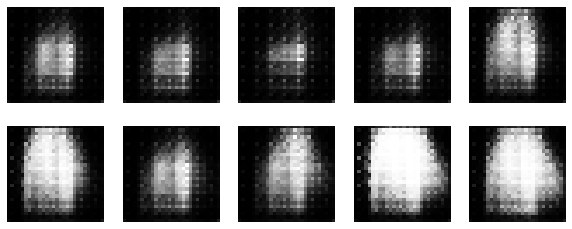

Epoch: (2/30), Batch: (0/938), D_Loss: 0.3754, G_Loss: 4.9023, D(x): 0.9395, G(D(z)): 0.0239 / 0.0057
Epoch: (2/30), Batch: (500/938), D_Loss: 0.3989, G_Loss: 4.1234, D(x): 0.9663, G(D(z)): 0.0114 / 0.0150
Epoch: (3/30), Batch: (0/938), D_Loss: 0.3373, G_Loss: 6.3158, D(x): 0.9141, G(D(z)): 0.0012 / 0.0014
Epoch: (3/30), Batch: (500/938), D_Loss: 0.3384, G_Loss: 4.0502, D(x): 0.8717, G(D(z)): 0.0013 / 0.0134
Epoch: (4/30), Batch: (0/938), D_Loss: 0.3486, G_Loss: 4.4472, D(x): 0.9192, G(D(z)): 0.0181 / 0.0087
Epoch: (4/30), Batch: (500/938), D_Loss: 0.3324, G_Loss: 4.4225, D(x): 0.8854, G(D(z)): 0.0045 / 0.0093
Epoch: (5/30), Batch: (0/938), D_Loss: 0.3286, G_Loss: 5.9012, D(x): 0.9110, G(D(z)): 0.0004 / 0.0018
Epoch: (5/30), Batch: (500/938), D_Loss: 0.3282, G_Loss: 6.1236, D(x): 0.8994, G(D(z)): 0.0015 / 0.0014
Epoch: (6/30), Batch: (0/938), D_Loss: 0.3545, G_Loss: 7.2397, D(x): 0.8189, G(D(z)): 0.0014 / 0.0004
Epoch: (6/30), Batch: (500/938), D_Loss: 0.3262, G_Loss: 7.0816, D(x): 0.8

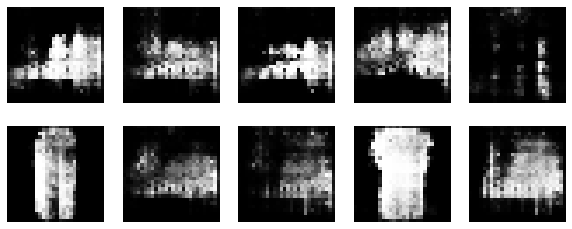

Epoch: (7/30), Batch: (0/938), D_Loss: 0.3302, G_Loss: 8.2330, D(x): 0.8859, G(D(z)): 0.0033 / 0.0001
Epoch: (7/30), Batch: (500/938), D_Loss: 0.3445, G_Loss: 6.0643, D(x): 0.9370, G(D(z)): 0.0090 / 0.0016
Epoch: (8/30), Batch: (0/938), D_Loss: 0.3292, G_Loss: 7.0428, D(x): 0.9209, G(D(z)): 0.0006 / 0.0005
Epoch: (8/30), Batch: (500/938), D_Loss: 0.3317, G_Loss: 6.7080, D(x): 0.9289, G(D(z)): 0.0000 / 0.0006
Epoch: (9/30), Batch: (0/938), D_Loss: 0.3290, G_Loss: 8.3657, D(x): 0.9201, G(D(z)): 0.0001 / 0.0001
Epoch: (9/30), Batch: (500/938), D_Loss: 0.3286, G_Loss: 6.6847, D(x): 0.9203, G(D(z)): 0.0003 / 0.0007
Epoch: (10/30), Batch: (0/938), D_Loss: 0.3318, G_Loss: 6.6072, D(x): 0.8967, G(D(z)): 0.0032 / 0.0010
Epoch: (10/30), Batch: (500/938), D_Loss: 0.3263, G_Loss: 7.7848, D(x): 0.8925, G(D(z)): 0.0001 / 0.0002
Epoch: (11/30), Batch: (0/938), D_Loss: 0.3256, G_Loss: 7.8423, D(x): 0.9013, G(D(z)): 0.0001 / 0.0002
Epoch: (11/30), Batch: (500/938), D_Loss: 0.3279, G_Loss: 7.1504, D(x):

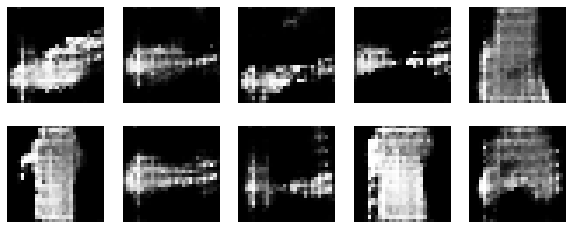

Epoch: (12/30), Batch: (0/938), D_Loss: 0.3287, G_Loss: 7.4233, D(x): 0.8762, G(D(z)): 0.0001 / 0.0003
Epoch: (12/30), Batch: (500/938), D_Loss: 0.3259, G_Loss: 6.2791, D(x): 0.9036, G(D(z)): 0.0004 / 0.0011
Epoch: (13/30), Batch: (0/938), D_Loss: 0.3261, G_Loss: 10.0276, D(x): 0.8892, G(D(z)): 0.0000 / 0.0000
Epoch: (13/30), Batch: (500/938), D_Loss: 0.3257, G_Loss: 9.0257, D(x): 0.9025, G(D(z)): 0.0000 / 0.0001
Epoch: (14/30), Batch: (0/938), D_Loss: 0.3261, G_Loss: 7.6298, D(x): 0.9049, G(D(z)): 0.0006 / 0.0003
Epoch: (14/30), Batch: (500/938), D_Loss: 0.3254, G_Loss: 8.0736, D(x): 0.9004, G(D(z)): 0.0000 / 0.0002
Epoch: (15/30), Batch: (0/938), D_Loss: 0.3254, G_Loss: 10.1540, D(x): 0.9030, G(D(z)): 0.0000 / 0.0000
Epoch: (15/30), Batch: (500/938), D_Loss: 0.3255, G_Loss: 10.4550, D(x): 0.9038, G(D(z)): 0.0001 / 0.0000
Epoch: (16/30), Batch: (0/938), D_Loss: 0.3270, G_Loss: 10.2197, D(x): 0.8840, G(D(z)): 0.0000 / 0.0000
Epoch: (16/30), Batch: (500/938), D_Loss: 0.3258, G_Loss: 7.9

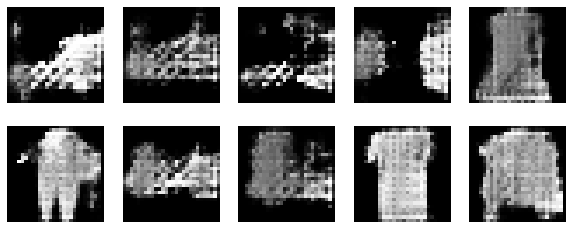

Epoch: (17/30), Batch: (0/938), D_Loss: 0.3277, G_Loss: 10.0403, D(x): 0.9156, G(D(z)): 0.0009 / 0.0000
Epoch: (17/30), Batch: (500/938), D_Loss: 0.3260, G_Loss: 11.1274, D(x): 0.8937, G(D(z)): 0.0001 / 0.0000
Epoch: (18/30), Batch: (0/938), D_Loss: 0.3268, G_Loss: 10.2428, D(x): 0.9152, G(D(z)): 0.0001 / 0.0000
Epoch: (18/30), Batch: (500/938), D_Loss: 0.3307, G_Loss: 10.0921, D(x): 0.8754, G(D(z)): 0.0021 / 0.0000
Epoch: (19/30), Batch: (0/938), D_Loss: 0.3254, G_Loss: 10.8322, D(x): 0.8944, G(D(z)): 0.0000 / 0.0000
Epoch: (19/30), Batch: (500/938), D_Loss: 0.3260, G_Loss: 7.8116, D(x): 0.8973, G(D(z)): 0.0001 / 0.0002
Epoch: (20/30), Batch: (0/938), D_Loss: 0.3256, G_Loss: 9.4722, D(x): 0.8948, G(D(z)): 0.0001 / 0.0000
Epoch: (20/30), Batch: (500/938), D_Loss: 0.3257, G_Loss: 8.6293, D(x): 0.8922, G(D(z)): 0.0002 / 0.0001
Epoch: (21/30), Batch: (0/938), D_Loss: 0.3258, G_Loss: 8.4800, D(x): 0.9058, G(D(z)): 0.0003 / 0.0001
Epoch: (21/30), Batch: (500/938), D_Loss: 0.3256, G_Loss: 10

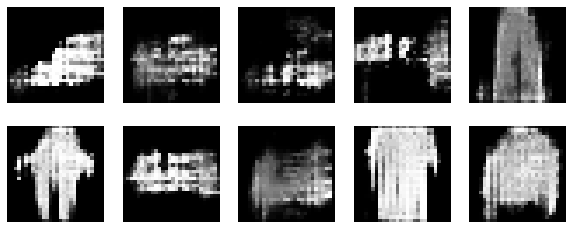

Epoch: (22/30), Batch: (0/938), D_Loss: 0.3255, G_Loss: 11.0232, D(x): 0.9071, G(D(z)): 0.0000 / 0.0000
Epoch: (22/30), Batch: (500/938), D_Loss: 0.3255, G_Loss: 9.1624, D(x): 0.9050, G(D(z)): 0.0002 / 0.0001
Epoch: (23/30), Batch: (0/938), D_Loss: 0.3252, G_Loss: 10.2069, D(x): 0.9013, G(D(z)): 0.0000 / 0.0000
Epoch: (23/30), Batch: (500/938), D_Loss: 0.3256, G_Loss: 11.1184, D(x): 0.9082, G(D(z)): 0.0000 / 0.0000
Epoch: (24/30), Batch: (0/938), D_Loss: 0.3254, G_Loss: 9.0843, D(x): 0.8953, G(D(z)): 0.0000 / 0.0001
Epoch: (24/30), Batch: (500/938), D_Loss: 0.3255, G_Loss: 9.3266, D(x): 0.9072, G(D(z)): 0.0000 / 0.0000
Epoch: (25/30), Batch: (0/938), D_Loss: 0.3252, G_Loss: 10.3648, D(x): 0.9005, G(D(z)): 0.0000 / 0.0000
Epoch: (25/30), Batch: (500/938), D_Loss: 0.3252, G_Loss: 10.2581, D(x): 0.9024, G(D(z)): 0.0000 / 0.0000
Epoch: (26/30), Batch: (0/938), D_Loss: 0.3256, G_Loss: 9.3437, D(x): 0.8958, G(D(z)): 0.0000 / 0.0000
Epoch: (26/30), Batch: (500/938), D_Loss: 0.3252, G_Loss: 10

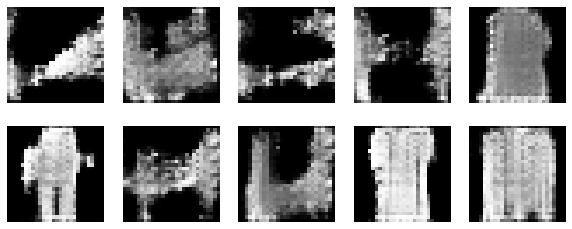

Epoch: (27/30), Batch: (0/938), D_Loss: 0.3262, G_Loss: 11.7965, D(x): 0.9109, G(D(z)): 0.0000 / 0.0000
Epoch: (27/30), Batch: (500/938), D_Loss: 0.3253, G_Loss: 11.7344, D(x): 0.8979, G(D(z)): 0.0000 / 0.0000
Epoch: (28/30), Batch: (0/938), D_Loss: 0.3258, G_Loss: 10.8264, D(x): 0.8904, G(D(z)): 0.0001 / 0.0000
Epoch: (28/30), Batch: (500/938), D_Loss: 0.3252, G_Loss: 11.4111, D(x): 0.9021, G(D(z)): 0.0000 / 0.0000
Epoch: (29/30), Batch: (0/938), D_Loss: 0.3254, G_Loss: 10.7733, D(x): 0.9012, G(D(z)): 0.0000 / 0.0000
Epoch: (29/30), Batch: (500/938), D_Loss: 0.3255, G_Loss: 11.1286, D(x): 0.9058, G(D(z)): 0.0000 / 0.0000
Epoch: (30/30), Batch: (0/938), D_Loss: 0.3253, G_Loss: 10.4120, D(x): 0.8962, G(D(z)): 0.0000 / 0.0000
Epoch: (30/30), Batch: (500/938), D_Loss: 0.3254, G_Loss: 12.0597, D(x): 0.9052, G(D(z)): 0.0000 / 0.0000


In [23]:
D = Discriminator().to(device)
G = Generator().to(device) 
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr= 1e-4)
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 1e-4)
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list = train(D,G,D_optimizer,G_optimizer,error,trainloader)



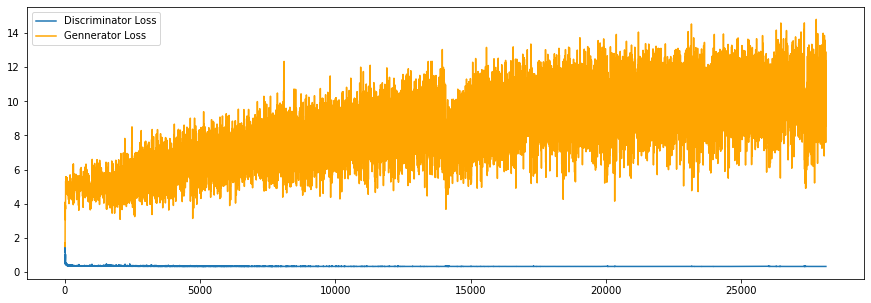

In [24]:
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    fig = plt.figure(figsize=(15,5))
    plt.plot(range(EPOCHS), D_loss_list, label = "Discriminator Loss")
    plt.plot(range(EPOCHS),G_loss_list, color = "orange", label = "Gennerator Loss")
    plt.legend()
    plt.show()
    
plot(D_loss_list, G_loss_list)

In [25]:
#test_noise = random_noise(10)
#generate_img(G,test_noise)

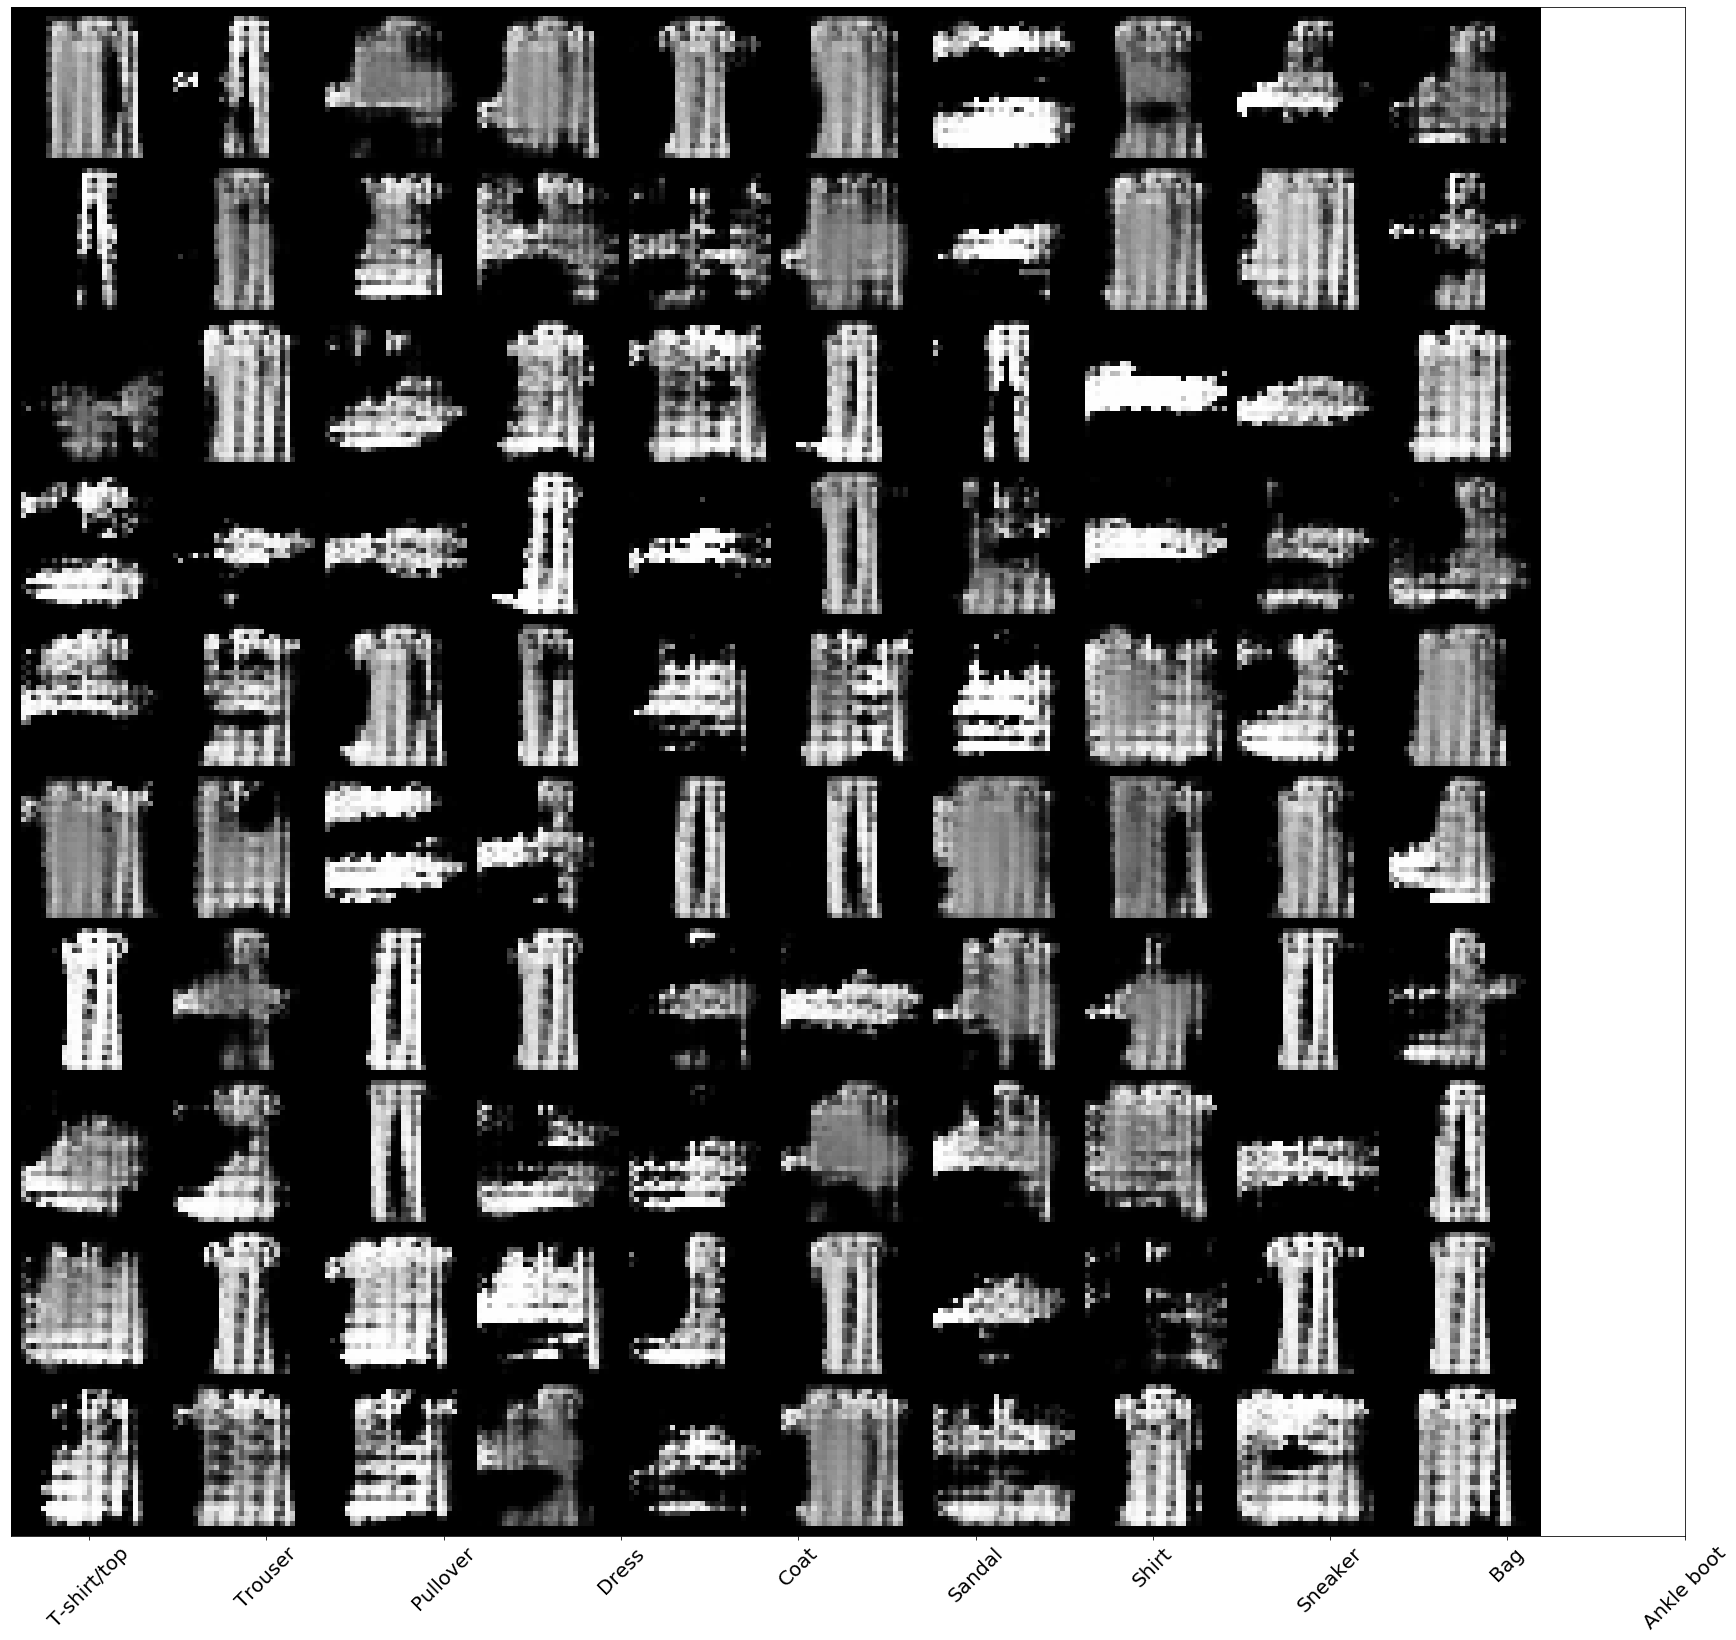

In [26]:
if not TRAINING_DATA:
    G.load_state_dict(torch.load("model/generator-dcgan2.pth"))
z = Variable(torch.randn(100, 100)).view(100,100,1,1).to(device)
classes = torch.LongTensor([i for _ in range(10) for i in range(NUM_CLASSES) ])
classes = Variable(one_hot[classes]).to(device)

images = G(z, classes).cpu()

grid = torchvision.utils.make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(30,30))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
#ax.axis('off')
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 350, 35),CLASSES, rotation=45, fontsize=20)

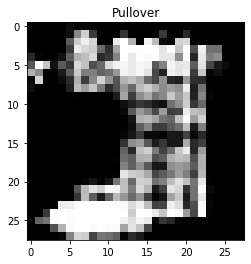

In [45]:
num =2
z = Variable(torch.randn(1, 100)).view(1,100,1,1).to(device)
classes = torch.LongTensor([num])
classes = Variable(one_hot[classes]).to(device)
images2 = G(z, classes).detach().cpu().squeeze()
plt.imshow(images2, cmap='gray')
plt.title(CLASSES[num])
plt.show()

In [28]:
print(np.arange(15, 350, 35))

[ 15  50  85 120 155 190 225 260 295 330]
